In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [170]:
train=pd.read_csv('Data_Train.csv')
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [171]:
train.shape

(10683, 11)

In [172]:
test=pd.read_csv('Test_set.csv')
test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR ? DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [173]:
test.shape

(2671, 10)

# Creating completed Flight dataset.
1. Since we have both train and test data we need to combine them and create single dataset for it.
2. It's been observed train data set has 'price' column which is missing from train data set and needs an update.
3. Many of the required columns are of type objects which require transformation.
4. Route and Total_Stops can be dropped citing issues with transformation.

In [174]:
# Concat train and test dataframes
data=pd.concat([train,test], axis=0)

In [175]:
data.shape

(13354, 11)

In [176]:
data.drop(['Route','Total_Stops','Additional_Info'], axis=1 ,inplace=True)

In [177]:
# Checking which all columns have null values
data.isnull().sum().sort_values(ascending=False)

Price              2671
Duration              0
Arrival_Time          0
Dep_Time              0
Destination           0
Source                0
Date_of_Journey       0
Airline               0
dtype: int64

In [178]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [179]:
data['Price'].fillna(data['Price'].median(), inplace=True)
#data['Route'].fillna('BLRDEL', inplace=True)
#data['Total_Stops'].fillna('nonstop', inplace=True)

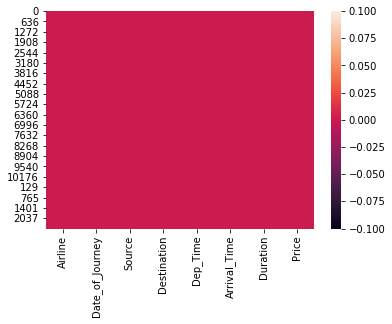

In [180]:
# Checking for null using HeatMap
sns.heatmap(data.isnull())

In [ ]:
plt.bar(data['Airline'],data['Price'])

plt.ylabel('Price')
plt.xlabel('Airline')
plt.show()

In [ ]:
data.columns

In [ ]:
# Encoding columns as part of transformation.
from sklearn.preprocessing import LabelEncoder 
le= LabelEncoder()

data['Airline'] = le.fit_transform(data['Airline'])
data['Date_of_Journey'] = le.fit_transform(data['Date_of_Journey'])
data['Source'] = le.fit_transform(data['Source'])
data['Destination'] = le.fit_transform(data['Destination'])
data['Dep_Time'] = le.fit_transform(data['Dep_Time'])
data['Arrival_Time'] = le.fit_transform(data['Arrival_Time'])
data['Duration'] = le.fit_transform(data['Duration'])


In [ ]:
data.describe()

In [ ]:
data.info()

In [ ]:
# Checking the zscore in order to normalize the data.
from scipy.stats import zscore
z= np.abs(zscore(data))
z

In [ ]:
# Verifying for the presence of zscore value of data with threshold of more than 3 std score.

threshold=3
print(np.where(z>3))

In [ ]:
# Removing the outliers having zscore value of more than 3.
flight_data=data[(z<3).all(axis=1)]
flight_data

Removed 127 records from the original data of 13345 set where zscore was more than 3 and created a new set.

In [ ]:
# Checking for skewed data
flight_data.skew()

In [ ]:
# Reducing the skewness with boxcox1p in order to avoid 0 encountered as negative while transformation.

from scipy.special import boxcox1p
# 0 -> log transform
# .5 -> square root transform


flight_data['Destination']=boxcox1p(flight_data['Destination'],0.5)

# Checking for skewed data
flight_data.skew()

In [ ]:
plt.figure(figsize=(8,8)) 
sns.heatmap(flight_data.corr(), annot=True, fmt=".2f") 
plt.suptitle("Correlation Map", fontsize=18)
plt.show()  

In [ ]:
# Setting x  by excluding Price column which is y here for prediction.
x=flight_data.drop(['Price'],axis=1)
x

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scale = StandardScaler()
#scale = MinMaxScaler()
x=scale.fit_transform(x)

In [ ]:
# Settng Y
y=flight_data['Price']
y

In [ ]:

max_score=0
for r_state in range(42,101):
    train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=.25,random_state=r_state)
    lm=LinearRegression()
    lm.fit(train_x,train_y)
    pred=lm.predict(test_x)
    score=lm.score(x,y)
    #print("Score corresponding to r_state: ",r_state," is ",score)
    if(score>max_score):
        max_score=score
        final_rstate=r_state
        
print("\n")
print("Max_accuracy_Score corresponding to final_r_state: ",final_rstate," is ",max_score)

In [ ]:
# Setting the test x & y values and using the random state from above step which is 92.

train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=.25,random_state=92)

In [ ]:
train_x.shape

In [ ]:
train_y.shape

In [ ]:
test_x.shape

In [ ]:
test_y.shape

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
KNN=KNeighborsRegressor(n_neighbors=10)
SV=SVR()
LR=LinearRegression()
DT=DecisionTreeRegressor(random_state=10)
LS = Lasso(alpha=0.01)
RD = Ridge(alpha=0.01)
EL = ElasticNet(alpha=0.01)
RF = RandomForestRegressor(n_estimators=100,random_state=50)
AD = AdaBoostRegressor()
GB = GradientBoostingRegressor()

In [ ]:
models=[]
models.append(('KNeighborsRegressor',KNN))
models.append(('SVR',SV))
models.append(('LinearRegression',LR))
models.append(('DecisionTreeRegressor',DT))
models.append(('Lasso',LS))
models.append(('Ridge',RD))
models.append(('ElasticNet',EL))
models.append(('RandomForestRegressor',RF))
models.append(('AdaBoostRegressor',AD))
models.append(('GradientBoostingRegressor',GB))

In [ ]:
Model=[]
score=[]
mae=[]
mse=[]
rmae=[]

for name,model in models:
    print("--------------",name,"--------------")
    Model.append(name)
    model.fit(train_x,train_y)
    print(model)
    pre=model.predict(test_x)
    
    # Metrics
    m1=mean_absolute_error(test_y,pred)
    print("Mean absolute error",m1)
    mae.append(m1)
           
    m2=mean_squared_error(test_y,pred)
    print("Mean squared error",m2)
    mse.append(m2)
    
    
    m3=np.sqrt(mean_squared_error(test_y,pred))
    print("Root Mean absolute error",m3)
    rmae.append(m3)
    
    #Model performance
    modelscore=model.score(test_x,test_y)
    print("Score: ",modelscore )
    score.append(modelscore*100)
    
    print("\n")

In [ ]:
result=pd.DataFrame({"Model": Model, "Score": score})
result

# From the above table GradientBoostingRegressor seems to be the best models with over 58% accuracy.

In [ ]:
# Saving the prediction data in a file.

predictData=pd.DataFrame(pre)
flight_data.to_csv('Price_Predict.csv')
predictData

In [ ]:
# Saving the model

from sklearn.externals import joblib
joblib.dump(GB,"GB_FlightPrice.pkl")